In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import cv2
import numpy as np
from tqdm import tqdm

device = torch.device('cuda:0')

/home/chaoqiy2/miniconda3/envs/moltext/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load MNIST Dataset

In [2]:
# for training set, we load the data and label
trainset = torchvision.datasets.MNIST(root='./data', train = True, download = True)
xtrain = trainset.data.numpy()
ytrain = trainset.targets.numpy()

# for test set, we load the data and label
testset = torchvision.datasets.MNIST(root='./data', train = False, download = True)
xtest = testset.data.numpy()
ytest = testset.targets.numpy()

print (xtrain.shape, ytrain.shape)
print (xtest.shape, ytest.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


/home/chaoqiy2/miniconda3/envs/moltext/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630836880/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### get data loader

In [3]:
# transform pixel value (0, 255) into {0,1}
xtrain = np.where(xtrain > 128, 1, 0)
xtrain = xtrain.astype(np.float32)

# transform pixel value (0, 255) into {0,1}
xtest = np.where(xtest > 128, 1, 0)
xtest = xtest.astype(np.float32)

batch_size = 256
trainloader = torch.utils.data.DataLoader([[xtrain[i], ytrain[i]] for i in range(len(ytrain))], \
                                          shuffle=True, batch_size=batch_size)
testloader = torch.utils.data.DataLoader([[xtest[i], ytest[i]] for i in range(len(ytest))], \
                                         shuffle=False, batch_size=batch_size)


## 2. Define the GAN Model (unconditioned)

In [4]:
class GAN(nn.Module):
    def __init__(self):
        super(GAN, self).__init__()
    
        self.discriminator = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(256, 128),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

        self.generator = nn.Sequential(
            nn.Linear(8, 128),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(128, 256),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(256, 28*28),
        )
        
    def discriminate(self, x):
        y = self.discriminator(x)
        return y

    def generate_fake(self, n_samples, device):
        eps = torch.randn(n_samples, 8).to(device)
        fake_images = torch.sigmoid(self.generator(eps))
        return fake_images
    
model = GAN()
model.to(device) # move model to GPU

GAN(
  (discriminator): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=128, out_features=1, bias=True)
    (5): Sigmoid()
  )
  (generator): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=784, bias=True)
  )
)

## 3. Model Training and Evaluation

In [5]:
# the loss function
loss = torch.nn.BCELoss()

# optimizers
opt_G = torch.optim.AdamW(model.generator.parameters(), lr=2e-4)
opt_D = torch.optim.AdamW(model.discriminator.parameters(), lr=2e-4)

# store the loss curve of D and G
curve_D, curve_G = [], []
for epoch in range(50):
    
    # store the loss over one epoch
    curve_G.append(0)
    curve_D.append(0)
    
    for data, label in trainloader:
        """ train discriminator """
        opt_D.zero_grad()

        batch_size = data.shape[0]
        # get real and fake images
        real_imgs = data.view(batch_size, -1).to(device)
        fake_imgs = model.generate_fake(batch_size, device).detach()
        # set their labels (real gets ones, and fake gets zeros)
        ones = torch.ones(batch_size, 1).to(device)
        zeros = torch.zeros(batch_size, 1).to(device)
        
        real_loss = loss(model.discriminator(real_imgs), ones)
        fake_loss = loss(model.discriminator(fake_imgs), zeros)
        loss_D = (real_loss + fake_loss) / 2

        loss_D.backward()
        opt_D.step()
        
        """ train generator """
        opt_G.zero_grad()
        # get fake images and label it as ones
        fake_imgs = model.generate_fake(batch_size, device)
        loss_G = loss(model.discriminator(fake_imgs), ones)

        loss_G.backward()
        opt_G.step()

        curve_G[-1] += loss_G.item()
        curve_D[-1] += loss_D.item()

    print (f"epoch: {epoch} --- loss of G: {curve_G[-1]}, loss of D: {curve_D[-1]}")
    

epoch: 0 --- loss of G: 695.0261586904526, loss of D: 50.8654022179544
epoch: 1 --- loss of G: 1274.2839531898499, loss of D: 7.094595664180815
epoch: 2 --- loss of G: 1529.9676642417908, loss of D: 4.5349901067093015
epoch: 3 --- loss of G: 1545.0338296890259, loss of D: 1.0954959698137827
epoch: 4 --- loss of G: 1692.133092880249, loss of D: 0.6184551562764682
epoch: 5 --- loss of G: 1743.416913986206, loss of D: 0.42476586886914447
epoch: 6 --- loss of G: 1695.3692665100098, loss of D: 0.5213441015803255
epoch: 7 --- loss of G: 1627.5502800941467, loss of D: 0.8701088452944532
epoch: 8 --- loss of G: 1657.6987328529358, loss of D: 0.8422141588525847
epoch: 9 --- loss of G: 1789.485619544983, loss of D: 0.5825252528447891
epoch: 10 --- loss of G: 1810.9714035987854, loss of D: 0.4312530436873203
epoch: 11 --- loss of G: 1749.4982838630676, loss of D: 0.391650324119837
epoch: 12 --- loss of G: 1584.6510038375854, loss of D: 1.518520547717344
epoch: 13 --- loss of G: 1656.820168018341,

## 4. Draw Loss Curve

Text(0.5, 1.0, 'Discriminator loss')

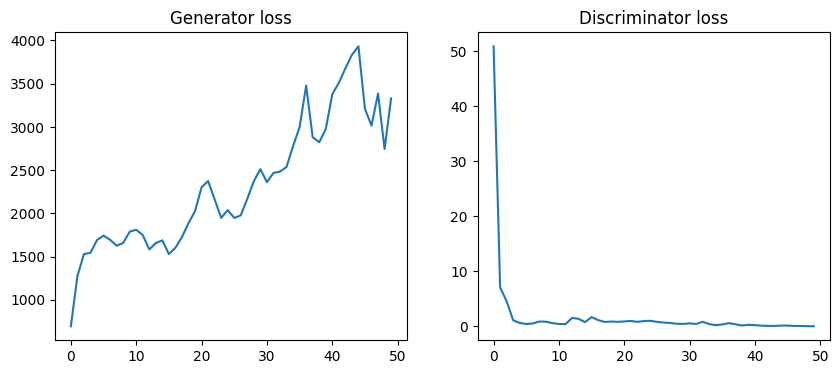

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(curve_G)
plt.title("Generator loss")

plt.subplot(122)
plt.plot(curve_D)
plt.title("Discriminator loss")

## 5. Generate new data (cannot control with digit)

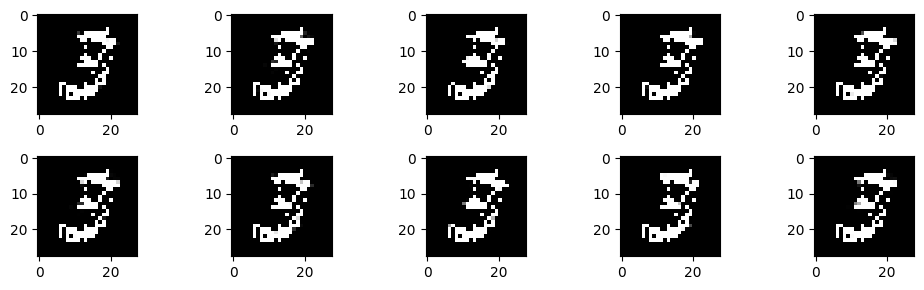

In [7]:
plt.figure(figsize=(10, 3))

model.eval()
with torch.no_grad():
    for l in range(10):
        plt.subplot(2, 5, l+1)
        
        # use decoder to generate the digit image
        rec = model.generate_fake(1, device).detach().cpu().numpy()
        rec = rec.reshape((1, 28, 28))[0]
        plt.imshow(rec, cmap="gray")

plt.tight_layout()
plt.show()

## 6. Try to generate digits with given labels

In [8]:
class ConditionalGAN(nn.Module):
    def __init__(self):
        super(ConditionalGAN, self).__init__()
    
        self.digit = nn.Embedding(10, 8)
        
        self.discriminator = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(256, 128),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(128, 11),
        )

        self.generator = nn.Sequential(
            nn.Linear(8, 128),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(128, 256),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(256, 28*28),
        )
        
    def discriminate(self, x):
        y = self.discriminator(x)
        return y

    def generate_fake(self, labels, device):
        eps = torch.randn(len(labels), 8).to(device)
        digit_emb = self.digit(labels.to(device))
        fake_images = torch.sigmoid(self.generator(eps + digit_emb))
        return fake_images
    
model2 = ConditionalGAN()
model2.to(device) # move model2 to GPU

ConditionalGAN(
  (digit): Embedding(10, 8)
  (discriminator): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=128, out_features=11, bias=True)
  )
  (generator): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=784, bias=True)
  )
)

In [9]:
# the loss function
loss = torch.nn.CrossEntropyLoss()

# optimizers
opt_G = torch.optim.AdamW(model2.generator.parameters(), lr=2e-4)
opt_D = torch.optim.AdamW(model2.discriminator.parameters(), lr=2e-4)
opt_emb = torch.optim.AdamW(model2.digit.parameters(), lr=2e-4)

curve_D, curve_G = [], []

for epoch in range(30):
    curve_G.append(0)
    curve_D.append(0)
    for data, label in trainloader:
        """ train discriminator """
        opt_D.zero_grad()
        opt_emb.zero_grad()
        
        batch_size = data.shape[0]
        real_imgs = data.view(batch_size, -1).to(device)
        fake_label = torch.LongTensor(np.arange(batch_size) % 10).to(device)
        fake_imgs = model2.generate_fake(fake_label, device)
        tens = (torch.ones(batch_size) * 10).long().to(device)
        
        label = torch.LongTensor(label).to(device)
        real_loss = loss(model2.discriminator(real_imgs), label)
        fake_loss = loss(model2.discriminator(fake_imgs), tens)
        loss_D = (real_loss + fake_loss) / 2

        loss_D.backward()
        opt_D.step()
        opt_emb.step()
        
        """ train generator """
        opt_G.zero_grad()
        opt_emb.zero_grad()
        fake_label = torch.LongTensor(np.arange(batch_size) % 10).to(device)
        fake_imgs = model2.generate_fake(fake_label, device)
        loss_G = loss(model2.discriminator(fake_imgs), fake_label)

        loss_G.backward()
        opt_G.step()
        opt_emb.step()
        
        curve_G[-1] += loss_G.item()
        curve_D[-1] += loss_D.item()

    print (f"epoch: {epoch} --- loss of G: {curve_G[-1]}, loss of D: {curve_D[-1]}")
    

epoch: 0 --- loss of G: 788.7719261646271, loss of D: 249.15589278936386
epoch: 1 --- loss of G: 1838.6043951511383, loss of D: 80.44264388084412
epoch: 2 --- loss of G: 2102.773599624634, loss of D: 50.53576349467039
epoch: 3 --- loss of G: 2326.7687826156616, loss of D: 41.09778410196304
epoch: 4 --- loss of G: 1991.3291754722595, loss of D: 39.16494046896696
epoch: 5 --- loss of G: 1733.1494302749634, loss of D: 40.30480021983385
epoch: 6 --- loss of G: 1569.832537651062, loss of D: 38.646454468369484
epoch: 7 --- loss of G: 1441.6888794898987, loss of D: 40.00721836090088
epoch: 8 --- loss of G: 1528.6731719970703, loss of D: 33.40029916167259
epoch: 9 --- loss of G: 1545.140658378601, loss of D: 31.359670847654343
epoch: 10 --- loss of G: 1746.6944994926453, loss of D: 30.3902755305171
epoch: 11 --- loss of G: 1790.6071848869324, loss of D: 28.08367743343115
epoch: 12 --- loss of G: 1714.8177065849304, loss of D: 29.220395367592573
epoch: 13 --- loss of G: 1755.838909626007, loss 

## 7. Generate new data (could control with digit)

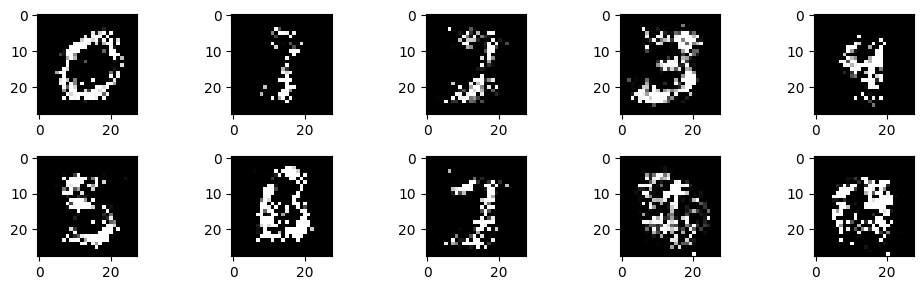

In [10]:
plt.figure(figsize=(10, 3))

model2.eval()
with torch.no_grad():
    for idx, l in enumerate(np.arange(10)):
        plt.subplot(2, 5, idx+1)
    
        # use decoder to generate the digit image
        rec = model2.generate_fake(torch.LongTensor([l]), device).detach().cpu().numpy()
        rec = rec.reshape((1, 28, 28))[0]
        plt.imshow(rec, cmap="gray")

plt.tight_layout()
plt.show()